# [IAPR 2020:][iapr2020] Lab 1 ‒  Image segmentation

**Author:** Christopher Hémon, Rami Azouz, Rayan Chaouch  
**Due date:** 26.03.2020

[iapr2018]: https://github.com/LTS5/iapr-2020

## Extract relevant data
We first need to extract the `lab-01-data.tar.gz` archive.
To this end, we use the [tarfile] module from the Python standard library.

[tarfile]: https://docs.python.org/3.6/library/tarfile.html

In [1]:
import tarfile
import os

data_base_path = os.path.join(os.pardir, 'data')
data_folder = 'lab-01-data'
tar_path = os.path.join(data_base_path, data_folder + '.tar.gz')
with tarfile.open(tar_path, mode='r:gz') as tar:
    tar.extractall(path=data_base_path)

## Part 1: Brain segmentation

Your goal: compute the size of the brain (in pixels) in a 2D image of a human head taken by Magnetic Resonance Imaging (MRI).
* Try as many methods as you can, the more the better.
* At least region growing and contour detection.

### 1.1 Brain image visualization

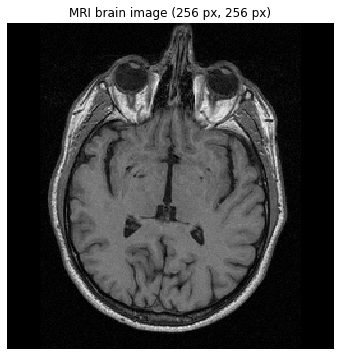

In [2]:
import skimage.io
import matplotlib.pyplot as plt
%matplotlib inline

# Load image
data_path = os.path.join(data_base_path, data_folder)
brain_im = skimage.io.imread(os.path.join(data_path, 'brain-slice40.tiff'))
im_h, im_w = brain_im.shape

fig, ax = plt.subplots(1, 1, figsize=(6, 6))
ax.imshow(brain_im, cmap='gray')
ax.set_title('MRI brain image ({} px, {} px)'.format(im_h, im_w))
ax.axis('off')
plt.show()

In [3]:
import numpy as np
from scipy import ndimage
import cv2
from skimage.morphology import binary_opening, binary_closing, disk
from skimage import exposure, filters, color, feature
import webcolors
from skimage.segmentation import active_contour
from skimage.filters import median, gaussian

### 1.2 Region growing

A region growing algorithm has been designed based on a threshold value set as growing criterion. In order to figure out the distribution of intensities among the pixels, we begin by displing the histogram of the image. 

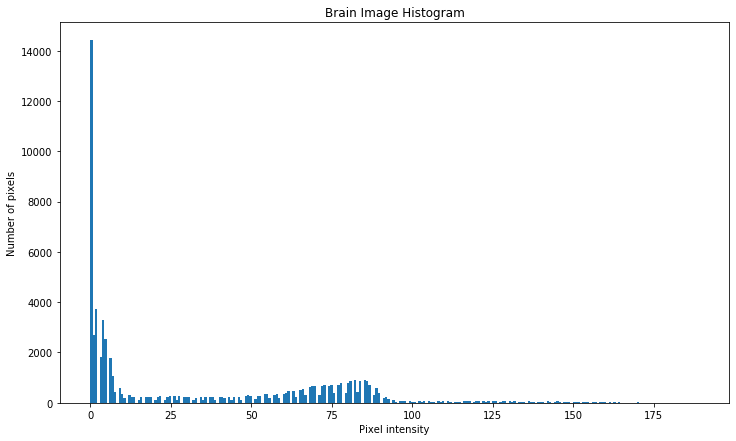

In [4]:
plt.figure(figsize=(12, 7))
ax = plt.hist(brain_im.ravel(), bins = 256)
plt.xlabel('Pixel intensity')
plt.ylabel('Number of pixels')
plt.title('Brain Image Histogram')
plt.show()

In [5]:
def get_unvisited_neighbors(img,xy,img_label, threshold):
    # Return unvisited neighbors
    (x,y) = xy
    (w,h) = img.shape
    neighbors = []
    
    for i in range(x-1,x+2):
        for j in range(y-1,y+2):
            if i>=0 and i<w and j>=0 and j<h:
                # if the neighbor pixel satisfies the threshold and hasn't been visited yet
                if img_label[i,j]==0 and img[i,j]>threshold:
                    neighbors.append((i,j))
                    
    return neighbors

In [6]:
def region_growing(img, seed, threshold):
    # Return a region starting from a pixel for a given threshold
    pixel_labels = np.zeros(img.shape)
    stack = []
    stack.append(seed)
    
    while len(stack)>0:
        pixel_to_label = stack.pop()
        pixel_labels[pixel_to_label] = 1
        neighbors = get_unvisited_neighbors(img,pixel_to_label,pixel_labels, threshold)
        
        for i in range(len(neighbors)):
            stack.append(neighbors[i])
            
            # pixel is labelled
            pixel_labels[neighbors[i]]=1
            
    return pixel_labels

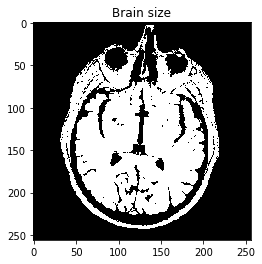

Brain segmented : 24105.0


In [7]:
# Seed and threshold definition
seed = (125,150)
threshold = 50

# Computing the growing region and ploting the image accordingly
segmented_img = region_growing(brain_im, seed, threshold)
plt.imshow(segmented_img,cmap='gray')
plt.title("Brain size")
plt.show()

# Computing the size of the region
brain_size_pixel=np.sum(segmented_img)
print("Brain segmented :",brain_size_pixel)

## Discusion and results analysis

The size of the brain was successfully measured by this method. To do so, we used an a priori approach. The user is requested to select the seed according to its need. In our case, selecting a pixel in the brain area. We will see how sensitive the results are according to this setting. 
The other parameter that has a major impact in the final result is the threshold. Thanks to the histogram plot, we have been able to narrow the range of possible values constituting the brain on the image that could be used as threshold.  

### Let's first observe the impact of filtering on our result

For this matter, we have been computing two filters: a median filter and a bilateral filter

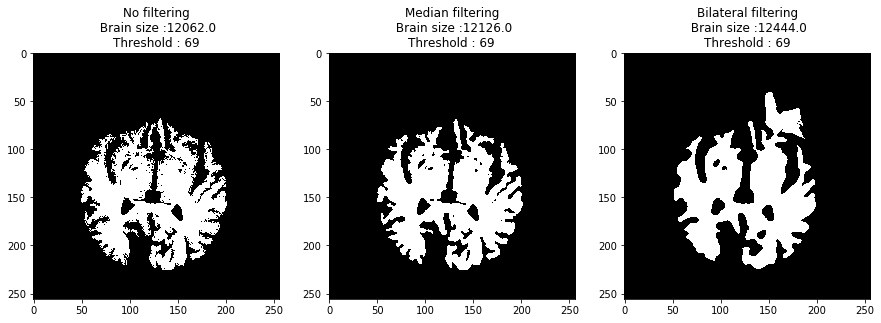

In [8]:
threshold = 69 

# No filtering
segmented_img_no = region_growing(brain_im, seed, threshold)
brain_size_pixel=np.sum(segmented_img_no)

# Median filtering:
brain_im_filtered = cv2.medianBlur(brain_im,3)
segmented_img_median = region_growing(brain_im_filtered, seed, threshold)
brain_size_pixel=np.sum(segmented_img_median)

# Bilateral filtering
brain_im_blurred = cv2.bilateralFilter(brain_im,9,75,75)
segmented_img_bilateral = region_growing(brain_im_blurred, seed, threshold)
brain_size_pixel=np.sum(segmented_img_bilateral)

fig,ax = plt.subplots(1,3,figsize=((15,15)))
ax[0].set_title("No filtering" + "\n Brain size :{}".format(np.sum(segmented_img_no)) + "\nThreshold : {}" .format(threshold))
ax[0].imshow(segmented_img_no,cmap='gray')

ax[1].set_title("Median filtering" + "\n Brain size :{}".format(np.sum(segmented_img_median))+ "\nThreshold : {}" .format(threshold))
ax[1].imshow(segmented_img_median,cmap='gray')

ax[2].set_title("Bilateral filtering" + "\n Brain size :{}".format(np.sum(segmented_img_bilateral))+ "\nThreshold : {}" .format(threshold))
ax[2].imshow(segmented_img_bilateral,cmap='gray')

We can observe that the image isn't greatly improved when applying the median filter. It tends to only reduce the amount of spot on the top of the brain image. On the other hand, the bilateral filter increase the smootheness of the picture but insert shapes that doesn't belong to the brain in the first place. 
According to the brain size, the three results are similar.

In the next part, we are going to discuss the impact of the seed selection on the region grown with no prior preprocessing operation.

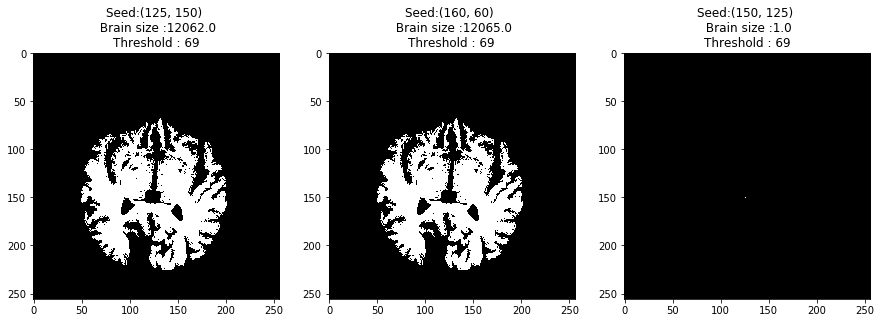

In [9]:
threshold = 69 

# seeds
seed1 = (125,150)
seed2 = (160,60)
seed3 = (150,125)

segmented_img_1 = region_growing(brain_im, seed1, threshold)
segmented_img_2 = region_growing(brain_im, seed2, threshold)
segmented_img_3 = region_growing(brain_im, seed3, threshold)

fig,ax = plt.subplots(1,3,figsize=((15,15)))
ax[0].set_title("Seed:{} " .format(seed1) + "\n Brain size :{}".format(np.sum(segmented_img_1))+ 
                "\nThreshold : {}" .format(threshold))
ax[0].imshow(segmented_img_1,cmap='gray')

ax[1].set_title("Seed:{} " .format(seed2) + "\n Brain size :{}".format(np.sum(segmented_img_2))+ 
                "\nThreshold : {}" .format(threshold))
ax[1].imshow(segmented_img_2,cmap='gray')

ax[2].set_title("Seed:{} " .format(seed3) + "\n Brain size :{}".format(np.sum(segmented_img_3))+ 
                "\nThreshold : {}" .format(threshold))
ax[2].imshow(segmented_img_3,cmap='gray')

From the last experiment, we can observe the impact from chosing the first pixel as seed for our algorithm. The firt image represent the case where we tried to select a pixel from a region where the grayscale of the brain was even. In the second figure, we've selected a spot where the grayscale is slightly darker but this action doesn't disrupt the result we obtain. However, the last seed was chosen in the middle of the brain on a black spot specifically. We can observe that no region was grown as the seed and its neighbors had all smaller grayscale values than the threshold. This method of chosing the seed is empirical. 
From a numerical point of view, we can notice that the first two plots have close brain size values and it is confirmed by the image itself. 

Finally, we will have a look on the consequences from setting different thresholds.

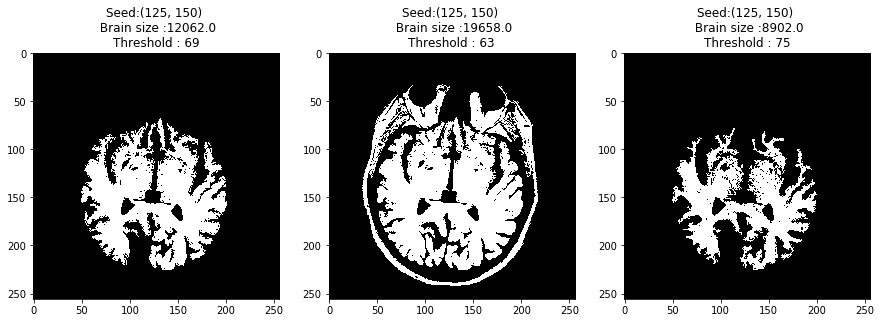

In [10]:
seed = (125,150)

# Thresholds
threshold1 = 69 
threshold2 = 63 
threshold3 = 75 

segmented_img_t1 = region_growing(brain_im, seed, threshold1)
segmented_img_t2 = region_growing(brain_im, seed, threshold2)
segmented_img_t3 = region_growing(brain_im, seed, threshold3)

fig,ax = plt.subplots(1,3,figsize=((15,15)))
ax[0].set_title("Seed:{} " .format(seed) + "\n Brain size :{}".format(np.sum(segmented_img_t1))+ 
                "\nThreshold : {}" .format(threshold1))
ax[0].imshow(segmented_img_t1,cmap='gray')

ax[1].set_title("Seed:{} " .format(seed) + "\n Brain size :{}".format(np.sum(segmented_img_t2))+ 
                "\nThreshold : {}" .format(threshold2))
ax[1].imshow(segmented_img_t2,cmap='gray')

ax[2].set_title("Seed:{} " .format(seed) + "\n Brain size :{}".format(np.sum(segmented_img_t3))+ 
                "\nThreshold : {}" .format(threshold3))
ax[2].imshow(segmented_img_t3,cmap='gray')

Finally, we can see the impact the threshold has on the final result. On the left, is the result we are keeping. it's the closest image that you can get to the brain. We can observe that when we select a threshold slightly lower, thus allowing  more dark pixel to be part of the region, obtain an increased brain size as we could expect.  On the other hand, increasing the threshold leaves fewer pixels getting through the threshold criterion. Thus the image isn't anymore the shape of the brain we expected. According to the brain size values, the best option is the first one as the second contain the skull also and the last one is smaller than the firat one. 

### 1.3 Contour detection
Add your implementation and discussion

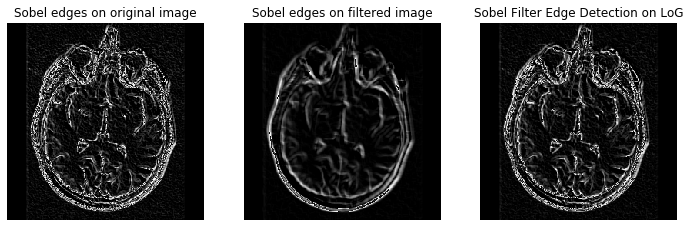

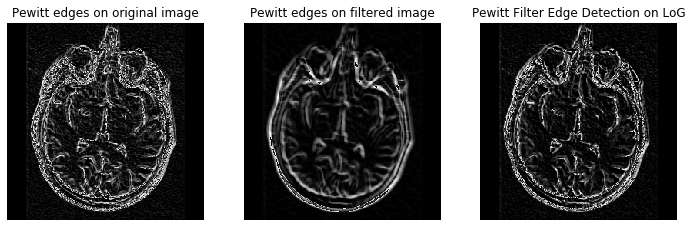

In [11]:
#simple 5x5 low pass filter
Kernel = np.ones((5,5),np.float32)/25
bf_im_nd = ndimage.filters.convolve(brain_im, Kernel)
bf_im = skimage.color.rgb2gray(bf_im_nd)

#Laplacien of Gaussian filter
def laplace_gaussian(size, sigma):
    size = int(size) // 2
    x, y = np.mgrid[-size:size+1, -size:size+1]
    normal = 1 / (2.0 * np.pi * sigma**2)
    lg =  np.exp(-((x**2 + y**2) / (2.0*sigma**2))) * normal
    return lg

LoG = laplace_gaussian(5,0.5)

def sobel_edges(im):
    #Sobel edge Detection
    K1 = [[1, 2, 1], [0, 0, 0],[-1, -2, -1]]
    K2 = [[0, 1, 1],[-1, 0, 1],[-2, -1, 0]]
    K3 = [[-1, 0, 1],[-2, 0, 2],[-1, 0, 1]]
    K4 = [[1,1,0],[1,0,-1],[0,-1,-2]]
    
    sob1 = cv2.filter2D(im,-1,np.float32(K1))
    sob2 = cv2.filter2D(im,-1,np.float32(K2))
    sob3 = cv2.filter2D(im,-1,np.float32(K3))
    sob4 = cv2.filter2D(im,-1,np.float32(K4))
    sobel = sob1 + sob2 + sob3 + sob4
    return sobel

def pewitt_edges(im):
#Pewitt edge Detection
    K1 = [[1, 1, 1],[0, 0, 0],[-1, -1, -1]]
    K2 = [[0, 1, 1],[-1, 0, 1],[-1, -1, 0]]
    K3 = [[-1, 0, 1],[-1, 0, 1],[-1, 0, 1]]
    K4 = [[1,1,0],[1,0,-1],[0,-1,-1]]
    
    pew1 = cv2.filter2D(im,-1,np.float32(K1))
    pew2 = cv2.filter2D(im,-1,np.float32(K2))
    pew3 = cv2.filter2D(im,-1,np.float32(K3))
    pew4 = cv2.filter2D(im,-1,np.float32(K4))
    pewitt = pew1 + pew2 + pew3 + pew4
    return pewitt

blog_f = cv2.filter2D(brain_im,-1,LoG)

se_bim = sobel_edges(brain_im)
se_fim = sobel_edges(bf_im)
se_logim = sobel_edges(blog_f)

pe_bim = pewitt_edges(brain_im)
pe_fim = pewitt_edges(bf_im)
pe_logim = sobel_edges(blog_f)


#plot figures
im_names1 = [ 'Sobel edges on original image', 'Sobel edges on filtered image','Sobel Filter Edge Detection on LoG']
im_names2 = [ 'Pewitt edges on original image', 'Pewitt edges on filtered image','Pewitt Filter Edge Detection on LoG']
fig, axes = plt.subplots(1, 3, figsize=(12, 12))
for ax, im, nm in zip(axes.ravel(), (se_bim,se_fim,se_logim), im_names1):
    ax.imshow(im,cmap='gray')
    ax.axis('off')
    ax.set_title(nm)
plt.show()
fig, axes = plt.subplots(1, 3, figsize=(12, 12))
for ax, im, nm in zip(axes.ravel(), (pe_bim,pe_fim,pe_logim), im_names2):
    ax.imshow(im,cmap='gray')
    ax.axis('off')
    ax.set_title(nm)
plt.show()

For our implementation of contour detection, we decided not to use some of python's in built functions such as the Canny edge dectector algorithme, but decided to build our own edge detections based on the in class material. 
### Our implementation:
Before starting we asked ourselves two questions. First, will we need to filter our image, and if so how will we proceed. Second what contour detection method would we implement. We decided to test all our options by implementing two noise reduction methods, and two edge detection methods using the Sobel and Pewitt matrices. We also compared these edge detections on the original image, to compare. We plotted our own convolution matrices and wrote our own Laplacien of Gaussian computational function so that we could easily modify the sigma variable. After some trials, we settles on a sigma of 0.5 as it offered the better sharp edges while still reducing the noise and smoothing out the image texture. The other filter we used was a simple 5x5 Kernel matrix that we convolute directly with the image.

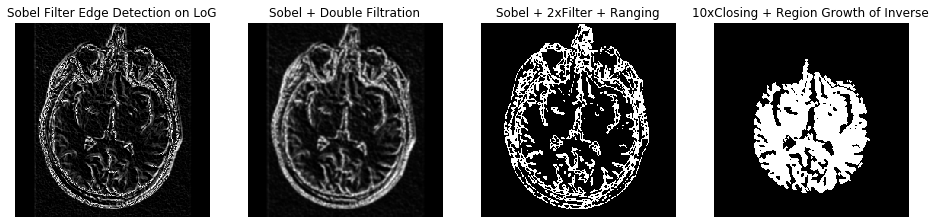

In [12]:
LoG2 = laplace_gaussian(5,1)
se2f_im = cv2.filter2D(se_logim,-1,LoG2)
serange_im = cv2.inRange(se2f_im,40,100)
closing_im = serange_im.copy()
for i in range (1,10):
    closing_im = binary_closing(closing_im)
brain_edge_im = region_growing(skimage.util.invert(closing_im),(125,150),0.5)

im_names3 = ['Sobel Filter Edge Detection on LoG', 'Sobel + Double Filtration', 'Sobel + 2xFilter + Ranging',
             '10xClosing + Region Growth of Inverse']
fig, axes = plt.subplots(1, 4, figsize=(16, 12))
for ax, im, nm in zip(axes.ravel(), (se_logim,se2f_im,serange_im,brain_edge_im), im_names3):
    ax.imshow(im, cmap = 'gray')
    ax.axis('off')
    ax.set_title(nm)
plt.show()

### Computation method:
From these edge detection images, we now need to isolate the brain. Here we will look at the single example of the Sobel matrix convoluted with a Laplacien of Gaussian low pass filter. First we will run the contour image through another Gaussian filter to smoothen out the texture. Then we decide to maximize a specific range of the histogram to get the most information on the contour. In order to get rid of the wholes in the edges, we need to apply a morphological transformation such as closing or diluting. Here we decided to close our image tenfold in order to obtain a good uniform edge of our brain. The trade-of is that we will loose brain volume, but at least we can compute the size of the brain with region growing now. In order to use our implementation of region growing, we need to get the inverse of our image. This gives a pretty good and detailed view of the brain. After trial and error, we settle on a seconf filter with a sigma of 1 and the range of 40 to 100 intesity for the range mask. Both these calculations can be improved through further numerical analytics which would give us the best range thresholds and the best sigma.

In [13]:
def brain_contour(im):
    f_im = cv2.filter2D(im,-1,LoG2)
    r_im = cv2.inRange(f_im,40,100)
    c_im = r_im.copy()
    for i in range (1,10):
        c_im = binary_closing(c_im)
    brain_eim = region_growing(skimage.util.invert(c_im),(125,150),0.5)
    return brain_eim

In order to implement this brain size calculation method to the rest of our edge detections and filters, we wrote a function. As stated before, the choices of the function and low-pass filter parameters we obtained through trial and error.

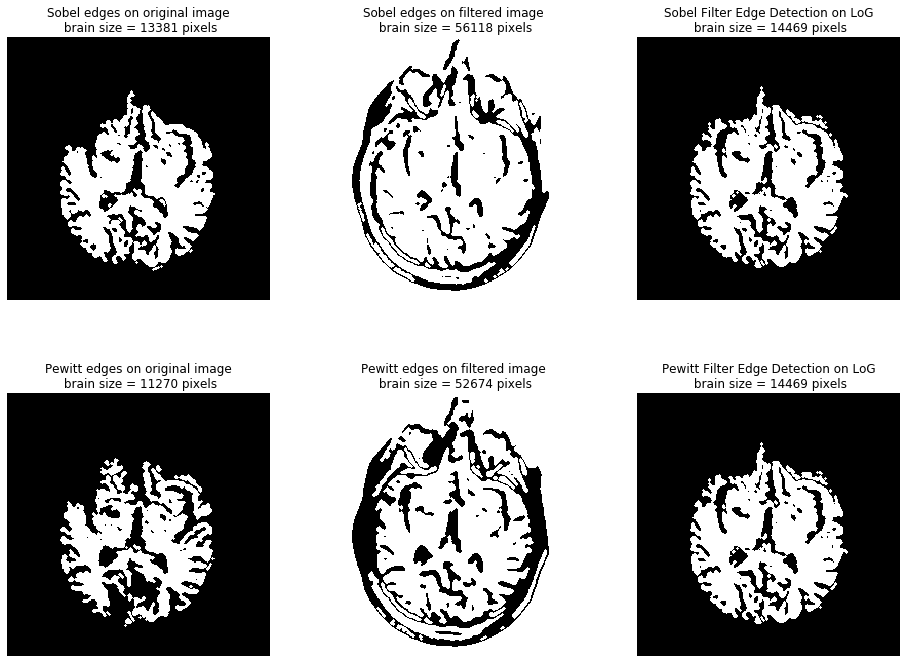

In [14]:
se_bim_brain = brain_contour(se_bim)
se_fim_brain = brain_contour(se_fim)
se_logim_brain = brain_contour(se_logim)

pe_bim_brain = brain_contour(pe_bim)
pe_fim_brain = brain_contour(pe_fim)
pe_logim_brain = brain_contour(pe_logim)

#plot figures
brain_sizes = [np.sum(se_bim_brain),np.sum(se_fim_brain),np.sum(se_logim_brain),np.sum(pe_bim_brain),
               np.sum(pe_fim_brain),np.sum(pe_logim_brain)]
im_names4 = [ 'Sobel edges on original image', 'Sobel edges on filtered image','Sobel Filter Edge Detection on LoG',
        'Pewitt edges on original image', 'Pewitt edges on filtered image','Pewitt Filter Edge Detection on LoG']
fig, axes = plt.subplots(2, 3, figsize=(16, 12))
for ax, im, nm, bs in zip(axes.ravel(), (se_bim_brain,se_fim_brain,se_logim_brain,pe_bim_brain,pe_fim_brain,pe_logim_brain), im_names4, brain_sizes):
    ax.imshow(im,cmap='gray')
    ax.axis('off')
    ax.set_title(nm+'\n brain size = {}'.format(bs.astype(int)) + ' pixels')
plt.show()

### Brain size:
Here we can see the estimate brain sizes when we applied our computation method to the other filters and contour detections. As we can see, not all of them worked properly, nottably both images issued from the simple kernel 5x5 filter did not manage to close their edges during our computational method. This is most likely because it was designed to operate with a Gaussian low pass-filter and not with the kernel. As we can see, the Gaussian filtration seems to be the best option when combined with a Sobel or Pewitt contour detection matrices. The original image brains are, as expected, smaller then the ones that went through smoothing filters.



### 1.4 Additional method(s)
Add your implementation and discussion

### First method
First we looked at active contouring. This is python function implemented in skimage that allows for simple contour detection through a progressive "snake" technique. The advantage is that it creates a perfectly uniform line that allows easy computation of the brain area. The downside is that it is not very precise and difficult to control with precision.

Brain size: 17518 pixels


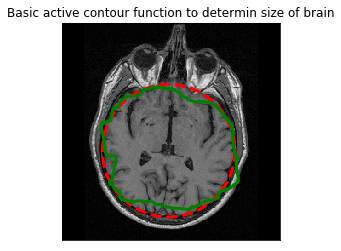

In [15]:
def area(contour):
    x=contour[:,0]
    y=contour[:,1]
    area=0.5*np.sum(y[:-1]*np.diff(x) - x[:-1]*np.diff(y))
    area=np.int16(np.abs(area))
    return area

s = np.linspace(0, 2*np.pi, 400)
r = 150 + 78*np.sin(s)
c = 125 + 78*np.cos(s)
init = np.array([r, c]).T

acontour = active_contour(median(brain_im, disk(2)), init, alpha=1e-5)

print("Brain size: {} pixels".format(area(acontour)))
fig, ax = plt.subplots(figsize=(4, 4))
ax.imshow(brain_im, cmap='gray')
ax.plot(init[:, 1], init[:, 0], '--r', lw=3)
ax.plot(acontour[:, 1], acontour[:, 0], '-g', lw=3)
ax.set_xticks([]), ax.set_yticks([])
ax.set_title("Basic active contour function to determin size of brain")

plt.show()

### Second method
The second method we looked at was image thresholds. Indeed even in the orinal image, the brain is gray compared to the rela
tive whiteness of the skull and the surounding black. If we find a correct range, we could potentialy only have the brain area left on our images

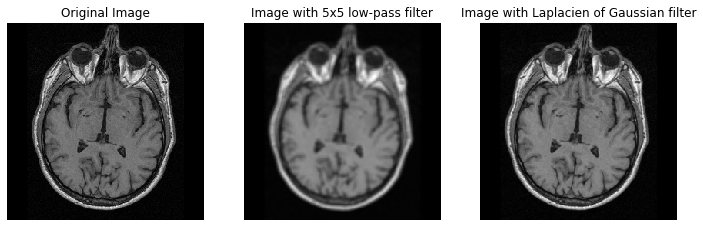

In [16]:
#plot figures
fig, ax = plt.subplots(1, 3, figsize=(12, 7))
ax[0].imshow(brain_im, cmap='gray')
ax[0].set_title('Original Image')
ax[0].axis('off')
ax[1].imshow(bf_im, cmap='gray')
ax[1].set_title('Image with 5x5 low-pass filter')
ax[1].axis('off')
ax[2].imshow(blog_f, cmap='gray')
ax[2].set_title('Image with Laplacien of Gaussian filter')
ax[2].axis('off')
plt.show()

We start by looking at the filtered images (5x5 kernel and LoG) and comparing them to the original image. We are looking for detail and smoothness. We therefore take the Gaussian low-pass filter to continue.

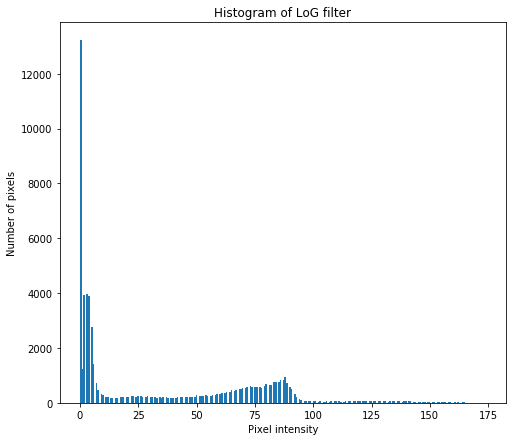

In [17]:
nb_bins = 256
# Display histogram
plt.figure(figsize=(8, 7))
plt.hist(blog_f.ravel(), bins=nb_bins)
plt.xlabel('Pixel intensity')
plt.ylabel('Number of pixels')
plt.title('Histogram of LoG filter')
plt.show()

In order to pick the best range, we look at the histogram of our filtered image. The most prominent pixels are black, do the pixels closer to 100 are the skull. It looks like our optimal range is somewhere between 50 and 90. We will look at several possibilities.

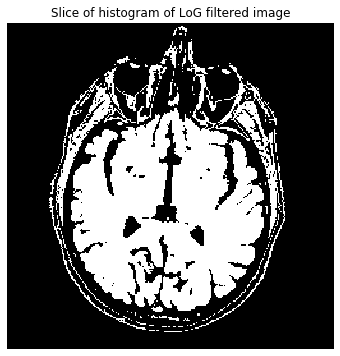

In [18]:
brange_im = cv2.inRange(blog_f,60,100)
fig, ax = plt.subplots(1, 1, figsize=(6, 6))
ax.imshow(brange_im, cmap='gray')
ax.set_title('Slice of histogram of LoG filtered image')
ax.axis('off')
plt.show()

This is an example on image when we apply the threshold with range 60 to 100. As we can see, the brain is a large white are in the center of the image. This is perfect for region growing.

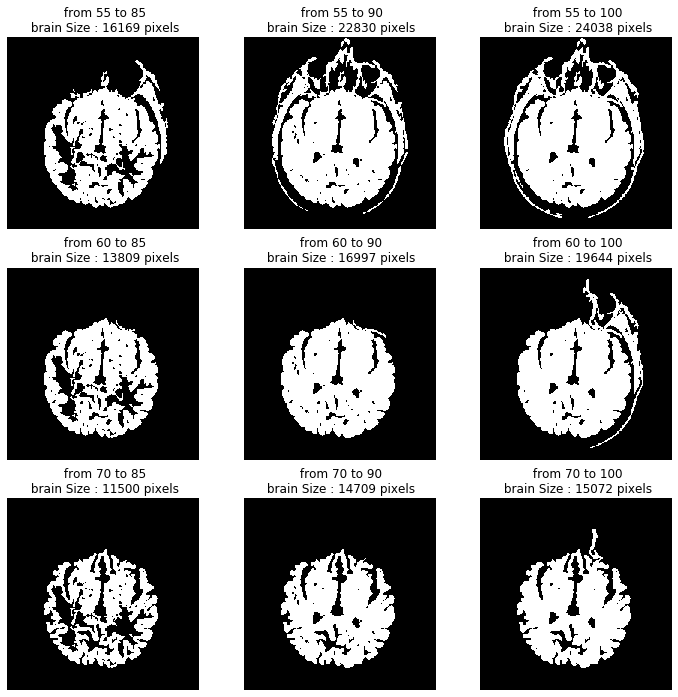

In [19]:
ig, axes = plt.subplots(3, 3, figsize=(12, 12))

for i,a in enumerate([55, 60, 70]):
    for j,b in enumerate([85, 90, 100]):
        brange_im = cv2.inRange(blog_f,a,b)
        b2fr_im = cv2.filter2D(brange_im,-1,LoG2)
        brain_range = region_growing(b2fr_im,(125,150),70)
        
        axes[i][j].imshow(brain_range, cmap='gray')
        axes[i][j].axis('off')
        axes[i][j].set_title(" from " + str(a) + " to " + str(b) +
                            "\n brain Size : " + str(np.int16(np.sum(brain_range))) + " pixels" )
        
fig.tight_layout()

Here we computed the area for different theshold ranges. As we can see, it is a relatively effective way of computing the size of hte brain. 

## Part 2: Shape/color segmentation

You will find hereafter three pictures taken under three different illuminations, containing some shapes with different colors. We ask you to create a routine to:

1. Count the number of shapes of each color.
2. Compute the total area (in pixels) of each color.

Please note that one specific challenge is to be robust to illumination changes. Therefore some kind of intensity normalization should probably be used.

**Note:** the routine(s) that you will write for this exercise will be useful for the final project as well, so pay special attention to it.

### 2.1 Visualization

In [20]:
# Load images
im_names = ['arena-shapes-01', 'arena-shapes-02', 'arena-shapes-03']
filenames = [os.path.join(data_path, name) + '.png' for name in im_names]
ic = skimage.io.imread_collection(filenames)
images = skimage.io.concatenate_images(ic)
print('Number of images: ', images.shape[0])
print('Image size: {}, {} '.format(images.shape[1], images.shape[2]))
print('Number of color channels: ', images.shape[-1])

Number of images:  3
Image size: 480, 640 
Number of color channels:  3


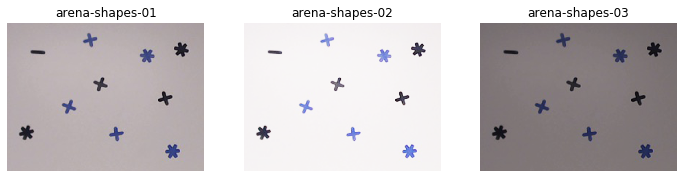

In [21]:
# Plot images
fig, axes = plt.subplots(1, 3, figsize=(12, 12))
for ax, im, nm in zip(axes.ravel(), images, im_names):
    ax.imshow(im)
    ax.axis('off')
    ax.set_title(nm)
plt.show()

# Useful functions

In [22]:
#Build a mask from the given image
def mask_build(img,threshold = 30,sigma = 2):
    # Convert to lab in order to extract luminosity
    lab = color.rgb2lab(img)
    img_gray = lab[:,:,0]
    # Lowpass filtering
    #img_gray = filters.gaussian(img_gray,sigma=sigma)
    # Build mask by thresholding
    # Simple because example background is uniform
    low_pixel = img_gray < threshold
    high_pixel = img_gray >= threshold
    img_gray[high_pixel]=0
    img_gray[low_pixel]=1    
    return img_gray

# https://stackoverflow.com/questions/9694165/convert-rgb-color-to-english-color-name-like-green-with-python
# We preferred using this function because it is more versatile
# Approximate the color to the closest one in the lookup table
def get_color_name(rgb_triplet):
    min_colours = {}
    for key, name in webcolors.CSS3_HEX_TO_NAMES.items():
        r_c, g_c, b_c = webcolors.hex_to_rgb(key)
        rd = (r_c - rgb_triplet[0]) ** 2
        gd = (g_c - rgb_triplet[1]) ** 2
        bd = (b_c - rgb_triplet[2]) ** 2
        min_colours[(rd + gd + bd)] = name
        color_text = min_colours[min(min_colours.keys())]
        if 'blue' in color_text :
            color_text = 'blue'
        else: color_text = 'gray'
    return color_text

# Finds the center of gravity of the shape and its corresponding color
def find_color(img, region):
    cx,cy = ndimage.measurements.center_of_mass(region)
    cx = cx.astype(int)
    cy = cy.astype(int)
    return (cx,cy,get_color_name(img[cx,cy,:]))

#Extract different shapes and assign the corresponding color to each picture
def shape_color_extraction(img,mask,threshold=0.5):
    (w,h) = mask.shape
    regions_color = []
    regions = []
    for i in range(w):
        for j in range(h):
            if mask[i,j] > threshold :
                shape = region_growing(mask,(i,j),threshold)
                mask[shape > threshold] = 0
                regions_color.append(find_color(img,shape))
                regions.append(shape)
    return regions_color , regions

## 2.2 Number of shapes of each color
Add your implementation and discussion

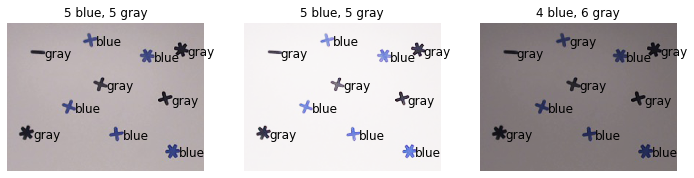

In [23]:
labels = []
fig, axes = plt.subplots(1, 3, figsize=(12, 12))
thresholds = [60,91,35]

for ax, im,threshold in zip(axes.ravel(), images,thresholds):
    nb_gray = 0
    nb_blue = 0
    mask = mask_build(im,threshold)
    features,regions = shape_color_extraction(im,mask)
    ax.imshow(im)
    for feature in features:
        ax.text(feature[1]+20, feature[0]+20, feature[2], fontsize=12)
        if feature[2] == 'blue':
            nb_blue+=1
        else: nb_gray +=1
    ax.axis('off')
    ax.set_title('{0} blue, {1} gray'.format(nb_blue,nb_gray))
plt.show()

We can see that in low luminosity, the algorithm struggles when finding the colors that are close to the black.
In the third image, the algorithm consider the blue "Plus" as a gray color. Humans can easily distinguish colors even in bad luminosity because they have learned it. However, human can also worngly interpret colors as we can see optical illusions.

### 2.3 Total area (in pixels) of each color
Add your implementation and discussion

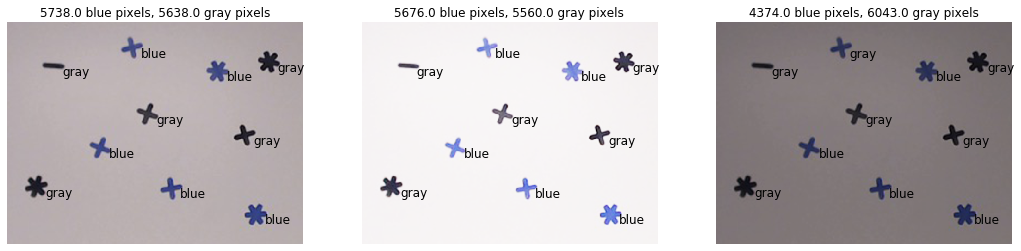

In [24]:
fig, axes = plt.subplots(1, 3, figsize=(18, 12))

for ax, im,threshold in zip(axes.ravel(), images,thresholds):
    nb_pixel_gray = 0
    nb_pixel_blue = 0
    mask = mask_build(im,threshold)
    features,regions = shape_color_extraction(im,mask)
    ax.imshow(im)
    for feature,region in zip(features,regions):
        ax.text(feature[1]+20, feature[0]+20, feature[2], fontsize=12)
        if feature[2] == 'blue':
            nb_pixel_blue += np.sum(region)
        else: nb_pixel_gray += np.sum(region)
    ax.axis('off')
    ax.set_title('{0} blue pixels, {1} gray pixels'.format(nb_pixel_blue,nb_pixel_gray))
plt.show()

We can see that the first to pictures have similar number of blue and gray pixels. The difference is maybe due to the difference in light conditions. This may affect the edges (Some pixels are overexposed in the picture of the middle and are eliminated by the threshold). The last one is a bit different due to the miss classification of the one feature.